#### Farouk Khlifi and Adrien Lemercier, Ecole Polytechnique, December 2020
#### Under the supervision of prof. Xavier Allamigeon and prof. Stéphane Gaubert

# Computation of central path

First, let's import the needed packages 

In [1]:
using LinearAlgebra
using PolynomialRoots
import Distances
using Plots
using Printf
using DelimitedFiles

Precison for BigFloat

In [2]:
setprecision(200)

200

## I. Lewis weights 

This section contains functions that will be used later as Lewis weights play a key role in Lee $\&$ Sideford paper.

The first two functions simply compute the Lewis weights from a matrix $A$. The algorithm is from "Lp Row Sampling by Lewis Weights" by Cohen and Peng that converges polynomially fast for $p<2$ (contraction argument). It is valid for $p<4$.

In [3]:
function LewisIterate(A::Array{BigFloat},p,w::Array{BigFloat})

    W_pow = zeros(BigFloat, size(A)[1],size(A)[1])
    for i = 1: size(A)[1]
        W_pow[i,i] = w[i]^(1/2.0-1/p) 
    end
    
    B = W_pow*A
    Sigma = B*inv(B' *B)*B'

    w_ret = zeros(BigFloat, size(A)[1])
    for i = 1: size(A)[1]
        w_ret[i] = (w[i]^(1-2/p)*Sigma[i,i])^(p/2) 
    end

    return w_ret
end

LewisIterate (generic function with 1 method)

In [4]:
function ApproxLewisWeights(A::Array{BigFloat},p,T)
    
    w = ones(BigFloat, size(A)[1])
    for i= 1:T
        w = LewisIterate(A,p,w)
    end
    return w
end

ApproxLewisWeights (generic function with 1 method)

Note : the closer $p$ is to 4, the longer the convegence.

The following function estimates the valuation of the Lewis weights (this time the coefficients of matrix $A$ are understood as the valuations of elments of the field of Puiseux series). This function will not be used in what follows.

In [5]:
function ApproxLewisWeightsValuation(A::Array{BigFloat},p,T,t::BigFloat, eps::BigFloat)
    if length(size(A)) == 1
        m = size(A)[1]
        n = 1
    else
        m = size(A)[1]
        n = size(A)[2]
    end
    delta = 1
    i=0
    B = ones(BigFloat,m,n)
    while delta > eps
        i += 1
        for k= 1:m
            for j=1:n
                B[k,j] = t ^ (i*A[k,j])
            end
        end
        w = ApproxLewisWeights(B,p,T)
        if i>1
            u_old = u
        end
        global u = [log(w[k])/(i*log(t)) for k=1:m]
        if i>1
            delta = sum(broadcast(abs,u - u_old))
        end
    end
    return u
end

ApproxLewisWeightsValuation (generic function with 1 method)

## II. Central path

In what follows, the equality constraints are in the form $A^{T}x = b$

### 1. Setting the parameters

We create functions that give the constraint matrix $A$, the vector of contraints $b$ and the vector $c$ used in the objective function $c \cdot x$ for some linear programs.

First, the conter-example of the paper of Xavier Allamigeon et al.

In [6]:
function LW_ineq(r::Int64,t_puiseux::BigFloat)

    A = zeros(BigFloat, 3r+1,2r)
    b = zeros(BigFloat, 3r+1,1)
    c = zeros(BigFloat, 2r,1)
    
    # defining A
    A[1,1], A[2,2] = 1 , 1
    A[3r,2r-1], A[3r+1,2r] = -1 , -1
    for j = 1:r-1
        A[3j,2j-1] ,   A[3j,2j+1] =  -t_puiseux , 1
        A[3j+1 ,2j],   A[3j+1 ,2j+1] =  -t_puiseux , 1
        A[3j+2 ,2j-1], A[3j+2,2j] , A[3j+2 ,2j+2] =  -t_puiseux^(1 - 2.0^(-j)) , -t_puiseux^(1 - 2.0 ^(-j)) , 1
    end
    
    #defining b
    b[1],b[2] = t_puiseux^2.0, t_puiseux
    
    #defining c
    c[1] = 1

    return (A,b,c)
end

LW_ineq (generic function with 1 method)

In [7]:
function LW_eq(r::Int64,t_puiseux::BigFloat)

    A,b,c = LW_ineq(r,t_puiseux)

    big_A = zeros(BigFloat, 3r+1,5r+1)
    big_c = zeros(BigFloat, 5r+1,1)

    big_A[1:3r+1,1:2r] = A
    big_A[1:3r+1,2r+1:5r+1] = Matrix{BigFloat}(I, 3r+1, 3r+1)

    big_c[1:2r] = c

    return (big_A',b,big_c)  # transposition because of the convention A^{T}x = b
end

LW_eq (generic function with 1 method)

Another linear program which we used as a first test for our numerical scheme.

In [8]:
function EX_eq(t_puiseux)
    
    A = zeros(BigFloat, 4,6)
    b = zeros(BigFloat, 4,1)
    c = zeros(BigFloat, 6,1)
    A[1, 1], A[1, 2], A[1, 3] = 1, 1, 1
    A[2, 1], A[2, 2], A[2, 4] = t_puiseux, -t_puiseux^2, 1
    A[3, 1], A[3, 2], A[3, 5] = -t_puiseux^3, t_puiseux, 1
    A[4, 1], A[4, 2], A[4, 6] = 1, -t_puiseux^2, 1
    b[1] = 2
    b[2] = 1
    b[3] = 1
    c[1] = 1
    c[2] = t_puiseux^3
    
    return (A',b,c)
end

EX_eq (generic function with 1 method)

Finally, we define ALL the problem parameters as global variables.

In [9]:
r = 3
t_puiseux = big(10.0^4)

X = LW_eq(r, t_puiseux)
A = X[1]
b = X[2]
c = X[3]

m = size(A')[1]
n = size(A')[2]
p = 1 - 1/(log(4*m))

T = 10    # for Lewis weights computation

10

### 2. Tools

First, the function that expresses the weights of the barrier in function of $x$, relying on previous functions that estimate Lewis weights.

In [10]:
function ApproxLewisWeightsx(A, p, T, x)
    
    Diag = zeros(BigFloat, size(A)[1], size(A)[1])
    for i = 1: size(A)[1]
        Diag[i,i] = x[i]
    end
    
    A_x = Diag*A
    c_0 = zeros(BigFloat,size(A)[1])
    for i =1: size(A)[1]
        try
            c_0[i] = size(A)[2]/(2* size(A)[1])
        
        catch
            c_0[i] = 1/(2* size(A)[1])
        end
    end
    return ApproxLewisWeights(A_x, p, T)+c_0
end

ApproxLewisWeightsx (generic function with 1 method)

In [11]:
function projector(A::Array{BigFloat}) 
    
    # projector onto A^T kernel
    # We make the following assumptions :
    # - A^T is rectangular, with more columns than lines
    # - A^T has full line rank
    
    n = size(A)[1]
    ans = Matrix{BigFloat}(I, n, n) - A*(inv(A'*A))*A'
    return ans
end

projector (generic function with 1 method)

A function that gives an initial point in the domain $A^{T}x = b$, $x\ge0$.

In [12]:
function x_init()  # A in BigFloat
    
    # We make the assumption that A^T "comes" from an inequality matrix,
    # i.e. slack vraiables have been added to vector x and A has been modified
    # accordingly (an identity matrix has been added on the right)
    
    m = size(A')[1]
    n = size(A')[2]
    B = ones(BigFloat,m,n-m)
    for k=1:m
        for j=1:n-m
            B[k,j] = A'[k,j]
        end        
    end
    a = 1.0
    bool = false
    while ! bool
        a = a/2
        x = ones(n-m,1)
        for k=1:n-m
            x[k]=a
        end
        c = B*x
        d = true
        for k=1:m
            if c[k]>b[k]
                d = false
            end
        end
        bool = d
    end
    ans = ones(BigFloat,n,1)
    for k=1:n-m
        ans[k]=a
    end
    for k=1:m
        ans[n-m+k] = b[k] - (B*ans[1:n-m])[k]
    end
    return ans
end

x_init (generic function with 1 method)

### 3. drawing the central path

Function which gives a good "starting couple" $(x,w)$, near the analytic center, for the ascending part leading to a point on the central path. We use an idea presented in Lee and Sidford paper: apply the main part of their algorithm, but with decreasing values of $t$.

In [13]:
function x_init_pauses(t1, alpha, lam1, u_bound, eps)
    x_0 = x_init()
    # println("initial x : ", x_0)
    w = ApproxLewisWeightsx(A,p,T,x_0)
    d = ones(BigFloat,n,1)
    for k=1:n
        d[k] = w[k]/x_0[k]
    end
    t = big(1.0)
    x = x_0
    count = 0
    delta = [1.]
    # println("d : ",d)
    # println()
    while t > t1 
        
        if sum(broadcast(abs,delta))>u_bound
            println("have made a stop in the decreasing part")
            while sum(broadcast(abs,delta))> eps

                grad = ones(BigFloat, n,1)
                inv_hess = zeros(BigFloat, n,n)
                for i = 1:n
                    grad[i] = t*d[i] - w[i]/x[i]    #  !!!!! vector d, not c
                end
                for i = 1:n
                    inv_hess[i,i] = x[i]^2/w[i]
                end
                y = inv(A'*inv_hess*A)*(A'*inv_hess*grad)    # solve linear system
                delta = inv_hess*(A*y - grad)                # Newton's step under constraint

                x = x + lam1*delta                           # update x

                w = ApproxLewisWeightsx(A,p,T,x)             # update w
                print("  ")
            end
            count =0  
        end
        
        grad = ones(BigFloat, n,1)
        inv_hess = zeros(BigFloat, n,n)
        for i = 1:n
            grad[i] = t*d[i] - w[i]/x[i]    #  !!!!! d instead of c
        end
        for i = 1:n
            inv_hess[i,i] = x[i]^2/w[i]
        end
        y = inv(A'*inv_hess*A)*(A'*inv_hess*grad)    # solve linear system
        delta = inv_hess*(A*y - grad)                # Newton's step under constraint
        
        x = x + lam1*delta                           # update x

        w = ApproxLewisWeightsx(A,p,T,x)             # update w
        
        t = t*(1-alpha)                              # update t
        
        
        # to monitor t, useful in practice
        """
        if count%100==0 
            println("delta norm : ",sum(broadcast(abs,delta)))
            println("t : ",t)
        end
        """
        count = count+1
    end

    return x,w
end

x_init_pauses (generic function with 1 method)

A function that computes central path points associated to the times in Time.

In [14]:
function central_path(Time, t1, alpha, lam1, lam2, u_bound, eps)

    l = size(Time)[1]
    x, w = x_init_pauses(t1, alpha, lam1, u_bound, eps)
    jo = size(x)[1]
    ans = ones(jo, l)
    t = t1
    delta = [1.0]
    counter = 0
    
    for i = 1:l
        while Time[i] > t
            grad = ones(BigFloat, n,1)
            inv_hess = zeros(BigFloat, n,n)
            for i = 1:n
                grad[i] = t*c[i] - w[i]/x[i]    #  !!!!! the real c of the objective function
            end
            for i = 1:n
                inv_hess[i,i] = x[i]^2/w[i]
            end
            y = inv(A'*inv_hess*A)*(A'*inv_hess*grad)    # solve linear system
            delta = inv_hess*(A*y - grad)                # Newton's step under constraint

            x = x + lam1*delta                           # update x

            w = ApproxLewisWeightsx(A,p,T,x)             # update w

            t = t*(1+alpha)                              # update t
            
            """
            if counter%100 == 0
                println("t : ", t)
                println("delta norm : ", sum(broadcast(abs,delta)))
            end
            """
            counter = counter+1
        end

        t = Time[i]

        while sum(broadcast(abs,delta))> eps
            grad = ones(BigFloat, n,1)
            inv_hess = zeros(BigFloat, n,n)
            for i = 1:n
                grad[i] = t*c[i] - w[i]/x[i]    #  !!!!! the real c of the objective function
            end
            for i = 1:n
                inv_hess[i,i] = x[i]^2/w[i]
            end
            y = inv(A'*inv_hess*A)*(A'*inv_hess*grad)    # solve linear system
            delta = inv_hess*(A*y - grad)                # Newton's step under constraint

            x = x + lam2*delta                  # update x, lam2 here and not lam1

            w = ApproxLewisWeightsx(A,p,T,x)    # update w
            
            """
            if counter%100 ==0    # PAS EN DUR
                println("inside while : ", sum(broadcast(abs,delta)))
            end
            """
            counter = counter +1
        end
        
        println("outside while, t = ", Time[i])
        
        for j = 1:jo          # x stocken in columns in ans
            ans[j,i] = x[j]
        end
        
    end
    
    # Post-processing part
    
    # We stock the two last coordinates of the original vector x, as well as their
    # values under log in t_puiseux base

    x = ones(l, 2)
    log_x = ones(l, 2)
    for i=1:l
        x[i, 1] = ans[2*r-1,i]
        x[i, 2] = ans[2*r,i]
    end  
    for i=1:l
        log_x[i, 1] = log(t_puiseux,ans[2*r-1,i])
        log_x[i, 2] = log(t_puiseux,ans[2*r,i])
    end
    
    # To save the data
    # writedlm("central-path.csv", x, ", ")
    # writedlm("log-central-path.csv", log_x, ", ")
    
    # To plot what we have computed

    """
    s1 = scatter(x[:,1], x[:,2], markersize = 5, markercolor=:red, xlabel="x2r-1", 
        ylabel="x2r", title="central path", legend=false, dpi=100)  
    s2 = scatter(log_x[:,1], log_x[:,2], markersize = 5, markercolor=:blue, xlabel="log_x2r-1", 
        ylabel="log_x2r", title="log central path",legend=false, dpi=100)
    plot(s1,s2, layout=(2,1))
    """
    
    s = scatter(log_x[:,1], log_x[:,2], markersize = 5, markercolor=:blue, xlabel="log(x_{2r-1})", 
        ylabel="log(x_{2r})", title="log central path",legend=false, dpi=100)
    plot(s)

end

central_path (generic function with 1 method)

We apply our numerical scheme on the counterexample.

outside while, t = 9.9999999999999999999999999999999999999999999999999999999999962e-09
outside while, t = 1.5848931924611108921819461927240106480883442917389322696882115e-08
outside while, t = 2.5118864315095770288400381725736925726318359008493804843712366e-08
outside while, t = 3.9810717055349692510164508362839201984121141901911915093542708e-08
outside while, t = 6.3095734448019299135938084483070983411623935356959945133214536e-08
outside while, t = 1.0000000000000000000000000000000000000000000000000000000000004e-07
outside while, t = 1.5848931924611108921819461927240106480883442917389322696882123e-07
outside while, t = 2.5118864315095770288400381725736925726318359008493804843712374e-07
outside while, t = 3.9810717055349692510164508362839201984121141901911915093542731e-07
outside while, t = 6.3095734448019299135938084483070983411623935356959945133214551e-07
outside while, t = 1.0000000000000000000000000000000000000000000000000000000000002e-06
outside while, t = 1.5848931924611108921819

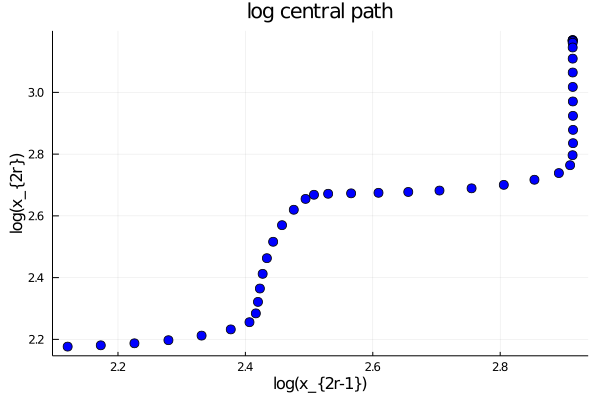

In [15]:
Time = [t_puiseux^lam for lam = [0.05*k for k= -40:0]]

central_path(Time, big(10^-40), 0.05, 10^-7, 10^-1, 10^10, 10^-7)  # Time, t1, alpha, lam, lam2, u_bound, eps

We observe that the shape of the tropical central path is the same as for the classical log barrier-function. 